In [85]:
import random
import numpy as np
import os
import collections
import pandas as pd
import time
import enum
from matplotlib import pyplot as plt

In [43]:
class ApproximateCounter():
    """
    Counts the frequency of every letter in a given text literary document.
    Metrics such as min, max and average number of occurences are also reported.
    Average pecentage of letter occurence in the text is also reported.
    """

    def __init__(self):
        self.student_counter = 106382
        random.seed = self.student_counter
        self.textFilesDirectory = os.path.join(os.getcwd(), 'TextFiles')
        
        self.counter = 0

        self.text_data = None
        self.count_method = None

        self.save_estimate = None
        self.save_counter = None


    def InitializeRegisters(self):
        # containers for holding actual counter and actual estimate of items
        # creating necessary columns

        columns = ['Letter'] + [f'Exp {exp_number}' for exp_number in range(1, self.n_experiments + 1)]
        self.counter_register = pd.DataFrame(columns=columns)
        # for exp_number in range(1, self.n_experiments + 1):
        #     self.counter_register = pd.concat([f'Exp {exp_number}'] = np.NaN


    def LoadTextFile(self, filename='sample'):
        self.filename = filename
        filename = filename + '.txt'
        text_file_path = os.path.join(self.textFilesDirectory, 'shakespeare', filename)
        with open(text_file_path, 'r', encoding="utf8") as file:
            text_data = file.readlines()

        # combine all lines from text into a big string
        self.text_data = ''.join(text_data)
        
        # remove all non-alphanumerics characters, and converts to upper(most imp) 
        self.text_data = ''.join(filter(str.isalpha, self.text_data)).upper()
    
    
    def Save2CSV(self, filename=None, dir_name='output'):
        """
        Saves register df to csv
        Args:
            filename [str] - filename to save csv without extension. default original textfile name
            dir_name [str] - output folder to save csv in. default 'output'
            save_estimate [bool] - whether to save letter:estimate or not. Default True, save file.
            save_counter [bool] - whether to save letter:count or not. Default True, save file.
        Writes:
            filename_estimate_decreaseprob [csv] - letter estimates for each trial of the experiment.
            filename_counter_exact [csv] - letter counter/approx frequency for each trial of the experiment.
        """
        
        if filename is not None:
            if not isinstance(filename, str):
                filename = str(filename)
        else:
            filename = self.filename

        # create directory to save outputs
        output_directory = os.path.join(self.textFilesDirectory, dir_name)
        if not os.path.exists(output_directory):
            os.mkdir(output_directory)
        
        if self.save_estimate is True:
            # filename_estimate_decreaseprob.csv
            estimate_filename = filename + '_' + self.count_method + '_estimate' + '.csv'
            estimate_file_path = os.path.join(output_directory, estimate_filename)
            self.estimate_register.to_csv(estimate_file_path, index = False, header=True)

        if self.save_counter is True:
            # filename_counter_exact.csv
            counter_filename = filename + '_' + self.count_method + '_counter' + '.csv'
            counter_file_path = os.path.join(output_directory, counter_filename)
            self.counter_register.to_csv(counter_file_path, index = False, header=True)


    def RegisterFormatter(self, register):
        """
        extract the compiled register.
        counts formatted as integer.
        NaN values replaced by 0's.
        Obtain metrics (min, max, std, var, average, avg %, mae)
        """
        register.fillna(0, inplace=True)
        # register.replace([np.inf, -np.inf],0, inplace=True)

        # set column types to int
        for exp in register.columns[1:]:
            register[exp] = register[exp].astype(int)
        
        # get metrics
        Min = register.iloc[:,1:].min(axis=1, skipna=True)
        Max = register.iloc[:,1:].max(axis=1, skipna=True)
        # Average = register.iloc[:,1:].mean(axis=1, skipna=True).apply(np.ceil).astype(int)
        Average = register.iloc[:,1:].mean(axis=1, skipna=True).apply(np.floor).astype(int)
        Std = register.iloc[:,1:].std(axis=1, skipna=True).round(4)
        Var = register.iloc[:,1:].var(axis=1, skipna=True).round(4)        
        
        # computing average percentage
        avg_sum = np.sum(Average)
        avg_percent = (Average/avg_sum)*100
        Average_Percent = avg_percent.round(4) # round to 2dps

        # computing the mean absolute error sum(|e_i|)/n
        MAE = register.iloc[:,1:].apply(lambda k: abs(k-Average[k.index])).mean(axis=1)

        # combining metrics
        metrics = pd.concat((Min, Max, Average, Average_Percent, MAE, Std, Var), axis=1)
        metrics_df = pd.DataFrame(metrics)
        metrics_df.columns = ['Minimum', 'Maximum', 'Average', 'Average %', 'MAE','STD', 'Variance']     
        
        # combine metrics with register and sort
        register = pd.concat((register, metrics_df), axis=1)
        register.sort_values(by='Average', ascending=False, inplace=True)

        return register


    def FormatRegisters(self):
        # computing estimates
        if self.save_estimate is True:

            self.estimate_register = self.counter_register.copy()

            if self.count_method == 'exact':
                self.estimate_register = self.estimate_register
            elif self.count_method == 'fixed':
                self.estimate_register = self.estimate_register.apply(lambda k: 2*k if k.name != 'Letter' else k)
            else: # decreasing probaibility
                self.estimate_register =  self.estimate_register.apply(lambda k: 2**k-1 if k.name != 'Letter' else k)
            self.estimate_register = self.RegisterFormatter(self.estimate_register)

        if self.save_counter is True:
            self.counter_register = self.RegisterFormatter(self.counter_register)   


    def Add2Register(self, exp_number, counter=None):
        """
        Implementation:
            Adds letter:frequency to register. If letter already exists, just add frequency to current exp_number. 
        Args:
            exp_number [int] - current experiment number
            counter [] - counter for each letter counted
        Updates:
            counter_register [] - add letter frequency/count to register database

        """
        # updating counter_register
        for letter in counter:
            if letter not in self.counter_register.values:
                self.counter_register = self.counter_register.append({'Letter':letter, f'Exp {exp_number}':int(counter[letter])}, ignore_index = True)
            else:
                self.counter_register.loc[self.counter_register['Letter']==letter, f'Exp {exp_number}'] = counter[letter]    


    def ExactCounter(self, n_experiments=1, save_estimate=True, save_counter=True):
        """
        Get all letter, frequency for each experiment.
        Add letter, frequency to register
        """
        # necessary global vars
        self.n_experiments = n_experiments
        self.save_estimate = save_estimate
        self.save_counter = save_counter
        self.count_method = 'exact'

        # create register and cols
        self.InitializeRegisters()
    
        for exp_number in range(1, self.n_experiments + 1):

            counters = dict()
            for letter_index in range(len(self.text_data)):
                letter = self.text_data[letter_index] 
                if letter in counters:
                    counters[letter] += 1
                else:
                    counters.update({letter : 1})
            
            self.Add2Register(exp_number, counter=counters)

        self.FormatRegisters()
        self.Save2CSV()


    def FixedProbCounter(self, n_experiments=1, save_estimate=True, save_counter=True):
        """
        Finds the exact count/frequency of distint letters in a literary work, with a probability of 1/2 of counting a new occurence.
        """
        # necessary global vars
        self.n_experiments = n_experiments
        self.save_estimate = save_estimate
        self.save_counter = save_counter
        self.count_method = 'fixed'

        # create register and experiment headings
        self.InitializeRegisters()
    
        for exp_number in range(1, self.n_experiments + 1):

            counters = dict()
            for letter in self.text_data:
                
                # using this because first occurences will always result in an error
                if letter in counters:
                    k = counters[letter] # count of letter already made
                    prob_not_increase = 1 - 1/2 # prob of increment is 1/2
                else:
                    prob_not_increase = 0

                exp_prob = random.random()
                if exp_prob > prob_not_increase:
                    if letter in counters:
                        counters[letter] += 1
                    else:
                        counters.update({letter : 1})
            
            self.Add2Register(exp_number, counter=counters)

        self.FormatRegisters()
        self.Save2CSV()


    def DecreasingProbCounter(self, n_experiments:int=1, save_estimate:bool=True, save_counter=True):
        """
        counts new letter occurence with decreasing probability each time. 
        For instance, the 10'th occurence will have probability 1/sqrt(2)**10 probability of getting counted.
        This means the more frequent 
        """
        # necessary global vars
        self.n_experiments = n_experiments
        self.save_estimate = save_estimate
        self.save_counter = save_counter
        self.count_method = 'decrease'

        # create register and cols
        self.InitializeRegisters()
    
        for exp_number in range(1, self.n_experiments + 1):

            counters = dict()
            for letter in self.text_data:
            
                # using this because first occurences will always result in an error
                if letter in counters:
                    k = counters[letter] # count of letter already made
                    prob_not_to_increase = 1 - (1/(np.sqrt(2)**(k))) # prob of increment is 1/sqrt(2)**k
                else:
                    prob_not_to_increase = 0

                # update counter if exp_prob is larger
                exp_prob = random.random()
                if exp_prob > prob_not_to_increase:              
                    if letter in counters:
                        counters[letter] += 1
                    else:
                        counters.update({letter : 1})
                        
            self.Add2Register(exp_number, counter=counters)

        self.FormatRegisters()
        self.Save2CSV()
            

    

In [44]:
literary_works = [
    'sample',
    # 'aMidsummerNightsDream-english',
    # 'aMidsummerNightsDream-french',
    # 'aMidsummerNightsDream-german',
    # 'hamlet-english',
    # 'hamlet-french',
    # 'hamlet-german',
    # 'juliusCaesar-english',
    # 'juliusCaesar-french',
    # 'juliusCaesar-german',
    # 'kingRichardIII-english',
    # 'kingRichardIII-french',
    # 'kingRichardIII-german',
    # 'macbeth-english',
    # 'macbeth-french',
    # 'macbeth-german',
    # 'merchantOfVenice-english',
    # 'merchantOfVenice-french',
    # 'merchantOfVenice-german',
    # 'othello-english',
    # 'othello-french',
    # 'othello-german',
    # 'romeoAndJuliet-english',
    # 'romeoAndJuliet-french',
    # 'romeoAndJuliet-german',
    # 'theTempest-english',
    # 'theTempest-french',
    # 'theTempest-german',
]

for literary_work in literary_works:
    AC = ApproximateCounter()
    AC.LoadTextFile(filename=literary_work)
    print('Working on', literary_work)
    
    print('started ExactCounter')
    start_exact = time.time()
    AC.ExactCounter(n_experiments=1, save_estimate=True, save_counter=True)
    print('It took (', time.time() - start_exact, ') secs')

    print('started FixedProbCounter')
    start_fixed = time.time()
    AC.FixedProbCounter(n_experiments=100, save_estimate=True, save_counter=True)
    print('It took (', time.time() - start_fixed, ') secs')

    print('started DecreasingProbCounter')
    start_decreased = time.time()
    AC.DecreasingProbCounter(n_experiments=100, save_estimate=True, save_counter=True)
    print('It took (', time.time() - start_decreased, ') secs')

    print('-'*35)
    
print('Done!!!')



Working on sample
started ExactCounter
It took ( 0.0370941162109375 ) secs
started FixedProbCounter
It took ( 0.7218344211578369 ) secs
started DecreasingProbCounter
It took ( 0.7673296928405762 ) secs
------------------------------
Done!!!


In [228]:
class ExpectedCounter:
    """
    Implementation:
        - These methods compute the Expected Counter values given the number of events, for the three counters.
        - The expected counter values are recursively computed.
    """
    total_no_events = 1
    def __init__(self):
        self.expected_counts = dict()

    def PlotExpectedCount(self):
        plt.plot(self.expected_counts.keys(), self.expected_counts.values())
        plt.title('Number of Occurence vs Expected Count')
        plt.xlabel('Number of Occurence (k)')
        plt.ylabel('Expected Count (Sk)')
        plt.show()


    def ExactExpectedCount(self, num_events=1):
        if num_events == 1:
            return 1
        return 1 + self.ExactExpectedCount(num_events-1)


    def FixedProbExpectedCount(self, num_events=1):
        if num_events == 1:
            return 1
        return 1/2 + self.FixedProbExpectedCount(num_events-1)


    def DecreasingProbExpectedCount(self, num_events=1):
        """
        recursively computes expected count with a decreasing probability
        """
        if num_events == 1:
            return 1
        self.recursive_counts += 1
        return 1/np.sqrt(2)**(num_events-1) + self.DecreasingProbExpectedCount(num_events-1)


    def Exact(self, total_no_events):
        """
        This produces counts that form a straight line. The function is identity.
        """
        self.__init__()
        self.total_no_events = total_no_events
        for event_num in range(1, self.total_no_events):
            self.expected_counts.update({event_num : self.ExactExpectedCount(num_events=event_num)})
        self.PlotExpectedCount()


    def FixedProb(self, total_no_events):
        """
        The values produced also form a slowly increasing linear function. compared to the exact counter.
        """
        self.__init__()
        self.total_no_events = total_no_events
        for event_num in range(1, self.total_no_events+1):
            self.expected_counts.update({event_num : self.FixedProbExpectedCount(num_events=event_num)})
        self.PlotExpectedCount()


    def DecreasingProb(self, total_no_events):
        """
        computes expected count for each event and plots these values
        """
        self.__init__()
        self.total_no_events = total_no_events

        for event_num in range(1, self.total_no_events+1):
            self.recursive_counts = 0
            self.expected_counts.update({event_num : self.DecreasingProbExpectedCount(num_events=event_num)})
        # self.PlotExpectedCount()

EC = ExpectedCounter()


In [233]:
EC.DecreasingProb(total_no_events=20)

In [234]:
EC.expected_counts

{1: (1, 0),
 2: (1.7071067811865475, 1),
 3: (2.2071067811865475, 2),
 4: (2.560660171779821, 3),
 5: (2.810660171779821, 4),
 6: (2.987436867076458, 5),
 7: (3.112436867076458, 6),
 8: (3.200825214724776, 7),
 9: (3.263325214724776, 8),
 10: (3.3075193885489353, 9),
 11: (3.3387693885489353, 10),
 12: (3.360866475461015, 11),
 13: (3.376491475461015, 12),
 14: (3.387540018917055, 13),
 15: (3.395352518917055, 14),
 16: (3.400876790645075, 15),
 17: (3.404783040645075, 16),
 18: (3.407545176509085, 17),
 19: (3.409498301509085, 18),
 20: (3.4108793694410897, 19)}

In [217]:
n=1
((1/2)**((n-1)/2))/((1/2)*np.log(1/2))

-2.8853900817779268

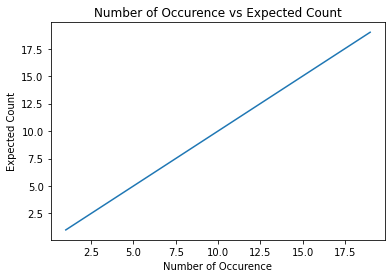

In [196]:
EC.Exact(total_no_events=20)

In [179]:
EC.expected_counts

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19}

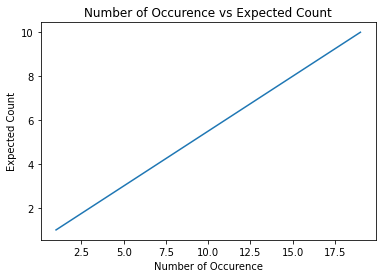

In [180]:
EC.FixedProb(total_no_events=20)

In [181]:
EC.expected_counts

{1: 1,
 2: 1.5,
 3: 2.0,
 4: 2.5,
 5: 3.0,
 6: 3.5,
 7: 4.0,
 8: 4.5,
 9: 5.0,
 10: 5.5,
 11: 6.0,
 12: 6.5,
 13: 7.0,
 14: 7.5,
 15: 8.0,
 16: 8.5,
 17: 9.0,
 18: 9.5,
 19: 10.0}

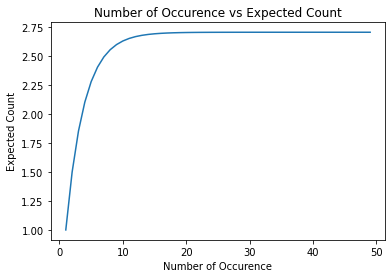

In [188]:
EC.DecreasingProb(total_no_events=50)

In [189]:
EC.expected_counts

{1: 1,
 2: 1.5,
 3: 1.8535533905932737,
 4: 2.1035533905932735,
 5: 2.2803300858899105,
 6: 2.4053300858899105,
 7: 2.4937184335382288,
 8: 2.5562184335382288,
 9: 2.600412607362388,
 10: 2.631662607362388,
 11: 2.6537596942744677,
 12: 2.6693846942744677,
 13: 2.6804332377305076,
 14: 2.6882457377305076,
 15: 2.6937700094585275,
 16: 2.6976762594585275,
 17: 2.7004383953225375,
 18: 2.7023915203225375,
 19: 2.7037725882545423,
 20: 2.7047491507545423,
 21: 2.705439684720545,
 22: 2.705927965970545,
 23: 2.706273232953546,
 24: 2.706517373578546,
 25: 2.706690007070047,
 26: 2.706812077382547,
 27: 2.706898394128297,
 28: 2.706959429284547,
 29: 2.707002587657422,
 30: 2.707033105235547,
 31: 2.7070546844219847,
 32: 2.707069943211047,
 33: 2.707080732804266,
 34: 2.7070883621987973,
 35: 2.7070937569954068,
 36: 2.7070975716926724,
 37: 2.707100269090977,
 38: 2.70710217643961,
 39: 2.7071035251387623,
 40: 2.7071044788130787,
 41: 2.707105153162655,
 42: 2.707105629999813,
 43: 2.707

In [194]:
(1/np.sqrt(2)**(0/2))+(1/np.sqrt(2)**(1/2))+(1/np.sqrt(2)**(2/2))

2.548003196440262